In [1]:
#compare optical flow algorithms
#1. differential framce displacement
#2. error cross correlation
#3. Lucas-Kanade
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from numpy.fft import fft
import glob
import time

In [2]:
#folder setup
pathImage='../scout_video_09/'
filePrefix='gimbal0_'
fileSuffix='.jpg'
idxStart=2000
idxEnd=2500

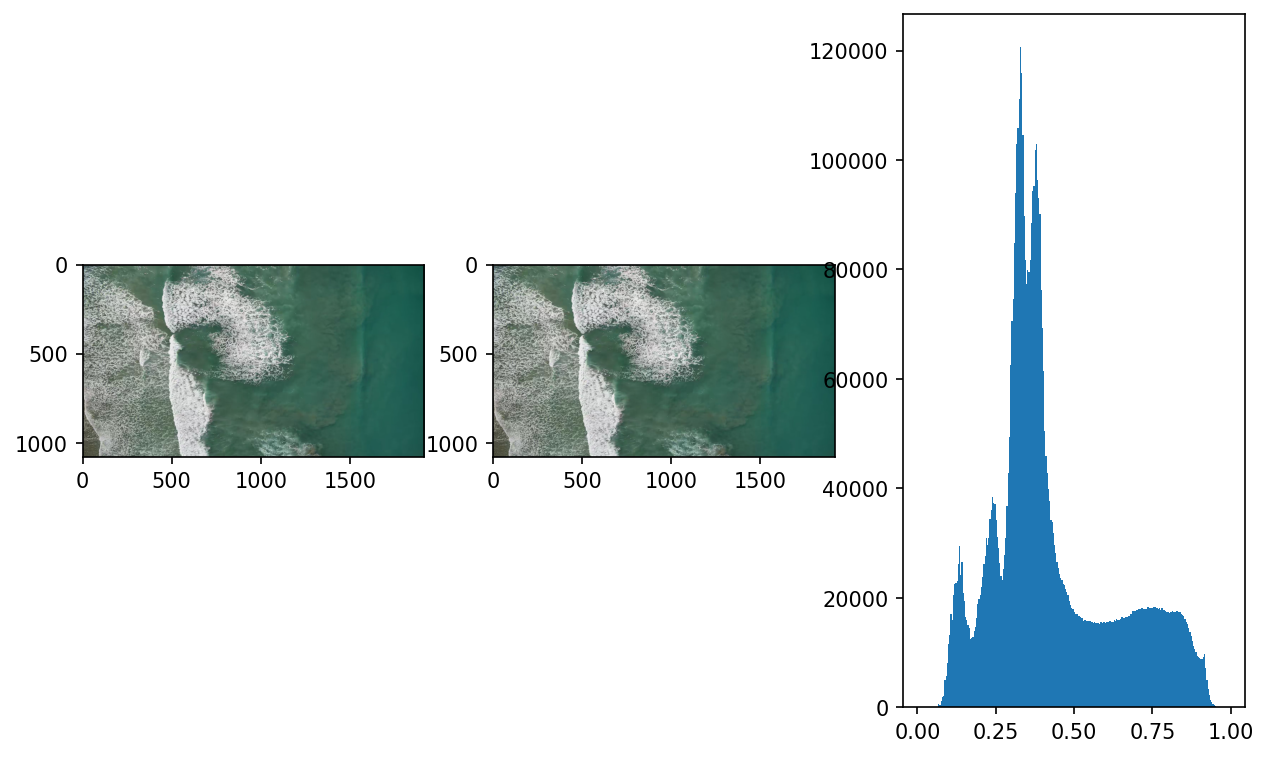

0.00390625
0.99609375
(1080, 1920, 3)
0.2890625
<class 'numpy.float64'>


In [3]:
#diplay image samples for optical flow analysis
idxFile=0
filename=filePrefix + str(idxFile + idxStart) + fileSuffix
img_0 = mpimg.imread(pathImage + filename) / 256
#imgplot_0 = plt.imshow(img_0)

idxFile=1
filename=filePrefix + str(idxFile + idxStart) + fileSuffix
img_1 = mpimg.imread(pathImage + filename) / 256

f=plt.figure(dpi=150)
f.set_figwidth(10)
f.set_figheight(6)
plt.subplot(1,3,1)
plt.imshow(img_0)
plt.subplot(1,3,2)
plt.imshow(img_1)
plt.subplot(1,3,3)
plt.hist(img_0.flatten(),255)
plt.show()

print(np.min(img_0))
print(np.max(img_0))
print(img_0.shape)
print(img_0[1079,1919,2])
print(type(img_0[0,0,0]))

gimbal0_2000.jpg
gimbal0_2001.jpg
(160, 160, 3)
DFD shape:  (100, 100)


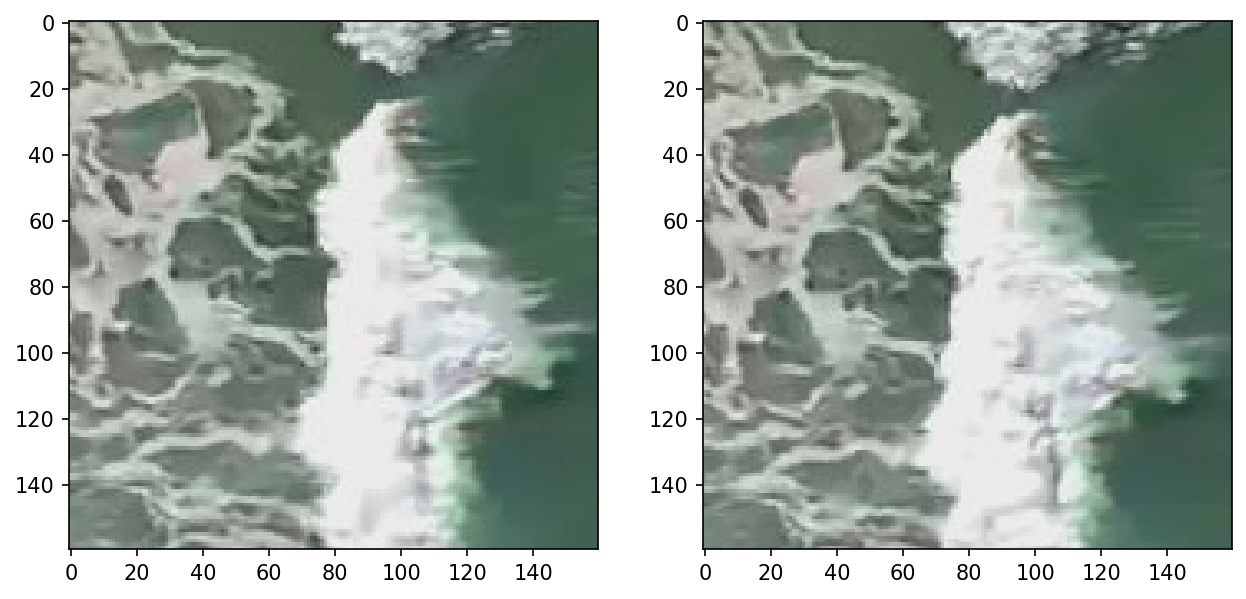

In [4]:
#Set cection of image to analyze
start = time.time()

tileSpan=15
dimX=1920
dimY=1080
searchRange=15
searchStep=1

noImages=2
idxStart=2000

idxFile=0
filename=filePrefix + str(idxFile + idxStart) + fileSuffix
img_ref = mpimg.imread(pathImage + filename) / 256
print(filename)

idxFile=1
filename=filePrefix + str(idxFile + idxStart) + fileSuffix
img_compare = mpimg.imread(pathImage + filename) / 256
print(filename)

#image portion to reduce computation loading and compare
X0=440
Y0=400

#X0=1500
#Y0=400

#X0=1700
#Y0=800

X1=X0+100
Y1=Y0+100

iX0=X0-searchRange-tileSpan
iX1=X1+searchRange+tileSpan
iY0=Y0-searchRange-tileSpan
iY1=Y1+searchRange+tileSpan

img_ref = img_ref[iY0:iY1, iX0:iX1] 
img_compare = img_compare[iY0:iY1, iX0:iX1] 
print(img_ref.shape)
(imgX,imgY,t)=img_ref.shape

DFD=np.ones((imgY-2*searchRange-2*tileSpan, imgX-2*searchRange-2*tileSpan))
(dimDFDy,dimDFDx)=DFD.shape
print("DFD shape: ", DFD.shape)
DFDx=np.zeros((imgY-2*searchRange-2*tileSpan, imgX-2*searchRange-2*tileSpan))
DFDy=np.zeros((imgY-2*searchRange-2*tileSpan, imgX-2*searchRange-2*tileSpan))

f=plt.figure(dpi=150)
f.set_figwidth(10)
f.set_figheight(6)
plt.subplot(1,2,1)
plt.imshow(img_ref)
plt.subplot(1,2,2)
plt.imshow(img_compare)

plt.show()

In [5]:
#Calculated Differential frame displacement
start = time.time()
for x in range(searchRange+tileSpan, imgX  - searchRange - tileSpan):
    for y in range(searchRange+tileSpan, imgY  - searchRange - tileSpan):
        ref = img_ref[y-tileSpan:y+tileSpan+1, x-tileSpan:x+tileSpan+1, :]
        #Differential Frame Displacement
        tDFD=np.zeros((2*searchRange+1, 2*searchRange+1))
        for i in range(-searchRange, searchRange+1, 1):
            for j in range(-searchRange, searchRange+1, 1):
                compare = img_compare[y-tileSpan+j:y+tileSpan+j+1, x-tileSpan+i:x+tileSpan+i+1, :]
                diff = np.mean((ref-compare)**2)
                #diff = np.mean((ref-compare)**2/(ref+compare)**2)
                tDFD[j+searchRange, i+searchRange] = diff
        (vY, vX)=np.unravel_index(tDFD.argmin(), tDFD.shape)
        tX=x - searchRange - tileSpan
        tY=y - searchRange - tileSpan
        DFD[tY,tX]=tDFD.min()
        DFDx[tY,tX]=vX - tileSpan
        DFDy[tY,tX]=vY - tileSpan
end = time.time()
print("run time: ", end - start)

run time:  170.21465802192688


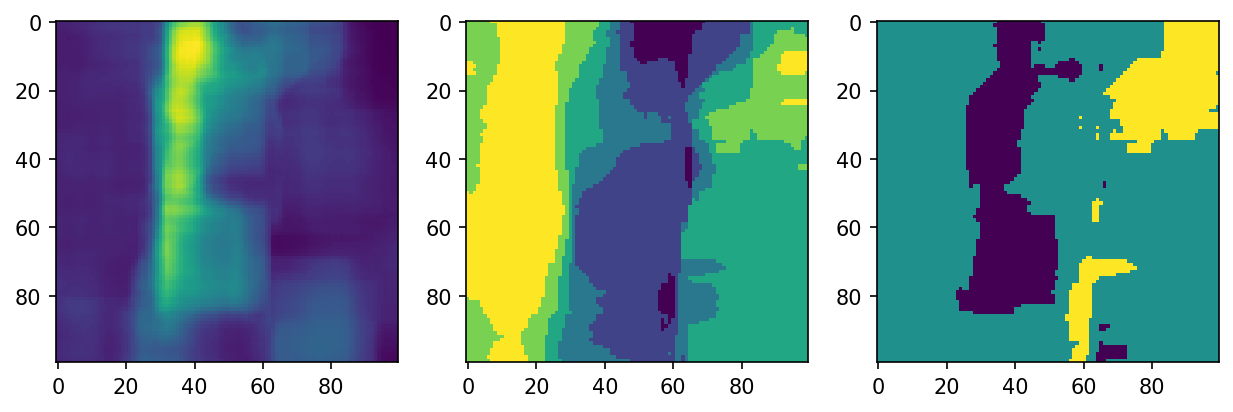

In [6]:
#plot DFD results
f=plt.figure(dpi=150)
f.set_figwidth(10)
f.set_figheight(6)
plt.subplot(1,3,1)
plt.imshow(DFD)
plt.subplot(1,3,2)
plt.imshow(DFDx)
plt.subplot(1,3,3)
plt.imshow(DFDy)

Compesantion vector Y:  5.0
DFD shape:  (100, 100)


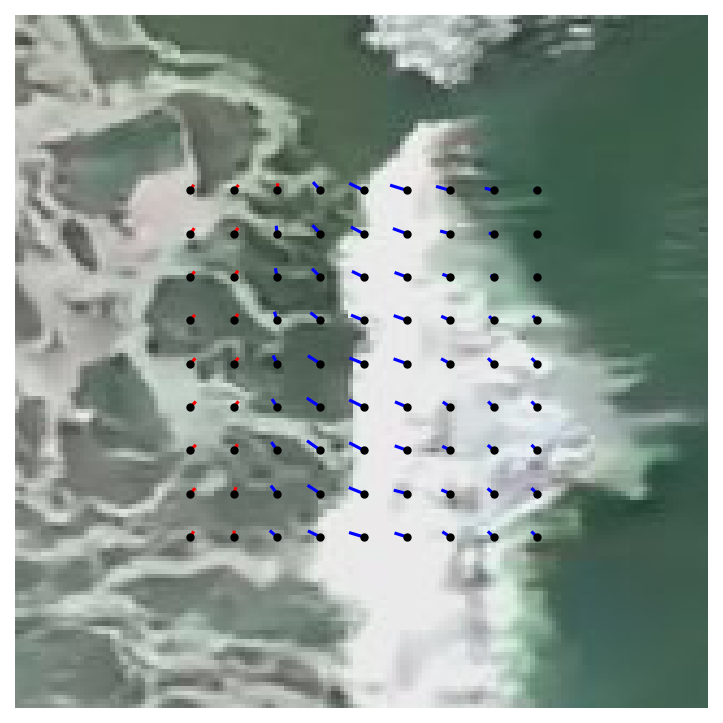

In [7]:
f=plt.figure(dpi=150)
f.set_figwidth(10)
f.set_figheight(6)

#plot flow vector
#drone speed compensation
windowSpanX=10
windowSpanY=10
windowShiftX=10
windowShiftY=10
#compensation parameters
speedY=5 #m/s
frameRate=10 #Hz
pixelSize=0.1 #m
compensateY= speedY / frameRate / pixelSize
print("Compesantion vector Y: ", compensateY)

print("DFD shape: ", DFD.shape)
(DFDheight,DFDwidth)=DFD.shape
imgplot_1 = plt.imshow(img_ref)

for x in range(windowSpanY, DFDwidth-windowSpanX+1, windowShiftX ):
    for y in range(windowSpanY, DFDheight-windowSpanY+1, windowShiftY):
        vX=np.mean(DFDx[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        vY=np.mean(DFDy[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        vX0=x + searchRange + tileSpan
        vY0=y + searchRange + tileSpan
        #print(vX0, vX0+vX , vY0, vY0+vY)
        if vX>0:
            lineColor='r'
        else:
            lineColor='b'    
        plt.plot([vX0, vX0+1*vX], [vY0, vY0+1*(vY-compensateY)], lineColor)
        plt.plot([vX0],[vY0], '.k', linewidth=2)
plt.axis('off')
plt.savefig('DFD1_test.png',bbox_inches='tight', pad_inches = 0)


In [8]:
#Compute Error Cross Correlation from paper
ECC=np.ones((imgY-2*searchRange-2*tileSpan, imgX-2*searchRange-2*tileSpan))
(dimDFDy,dimDFDx)=ECC.shape
ECCx=np.zeros((imgY-2*searchRange-2*tileSpan, imgX-2*searchRange-2*tileSpan))
ECCy=np.zeros((imgY-2*searchRange-2*tileSpan, imgX-2*searchRange-2*tileSpan))

start = time.time()
for x in range(searchRange+tileSpan, imgX  - searchRange - tileSpan):
    for y in range(searchRange+tileSpan, imgY  - searchRange - tileSpan):
        ref = img_ref[y-tileSpan:y+tileSpan+1, x-tileSpan:x+tileSpan+1, :]
        #ECC
        tECC=np.zeros((2*searchRange+1, 2*searchRange+1))
        for i in range(-searchRange, searchRange+1, 1):
            for j in range(-searchRange, searchRange+1, 1):
                compare = img_compare[y-tileSpan+j:y+tileSpan+j+1, x-tileSpan+i:x+tileSpan+i+1, :]
                corr = np.sum(1 - np.sum(np.abs(ref-compare)) / np.sum(ref+compare) )
                tECC[j+searchRange, i+searchRange] = corr
        (vY, vX)=np.unravel_index(tECC.argmax(), tECC.shape)
        tX=x - searchRange - tileSpan
        tY=y - searchRange - tileSpan
        ECC[tY,tX]=tECC.max()
        ECCx[tY,tX]=vX - tileSpan
        ECCy[tY,tX]=vY - tileSpan
end = time.time()
print("run time: ", end - start)

run time:  279.1838278770447


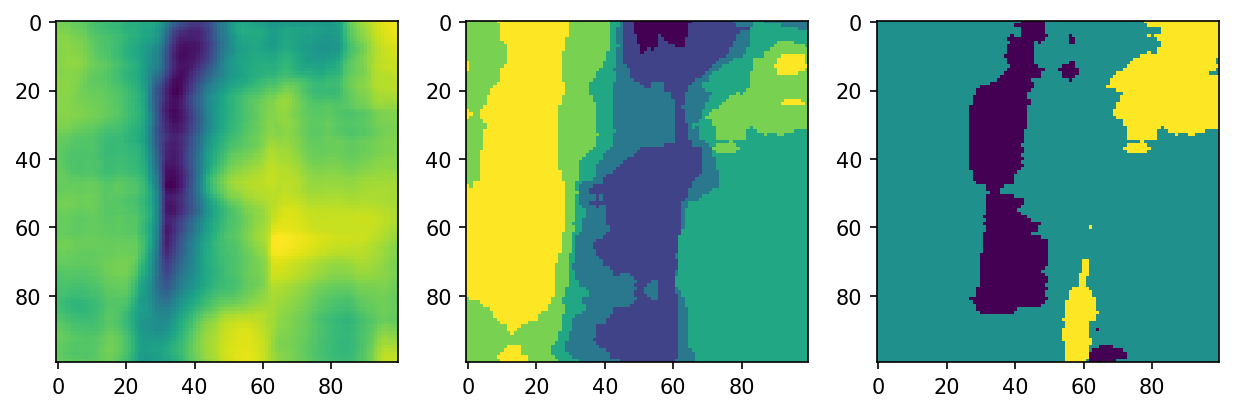

In [9]:
f=plt.figure(dpi=150)
f.set_figwidth(10)
f.set_figheight(6)
plt.subplot(1,3,1)
plt.imshow(ECC)
plt.subplot(1,3,2)
plt.imshow(ECCx)
plt.subplot(1,3,3)
plt.imshow(ECCy)

In [10]:
#Prepare Lucas-Kanade
print(img_0.shape)
img_0_gray = ( img_0[:,:,0] + img_0[:,:,1] + img_0[:,:,2] )/3
img_0_gray_grad_y = img_0_gray[1:dimY,   0:dimX-1] - img_0_gray[0:dimY-1, 0:dimX-1]
img_0_gray_grad_x = img_0_gray[0:dimY-1, 1:dimX] - img_0_gray[0:dimY-1, 0:dimX-1]
print(img_1.shape)
img_1_gray = ( img_1[:,:,0] + img_1[:,:,1] + img_1[:,:,2] )/3
img_1_gray_grad_y = img_1_gray[1:dimY,   0:dimX-1] - img_1_gray[0:dimY-1, 0:dimX-1]
img_1_gray_grad_x = img_1_gray[0:dimY-1, 1:dimX] - img_1_gray[0:dimY-1, 0:dimX-1]

img_diff = (img_1_gray - img_0_gray)*10

grad_x = img_1_gray_grad_x[iY0:iY1, iX0:iX1] 
grad_y = img_1_gray_grad_y[iY0:iY1, iX0:iX1] 
diff_t = img_diff[iY0:iY1, iX0:iX1] 

print(iY0,iY1,iX0,iX1)
print(diff_t.shape)

(1080, 1920, 3)
(1080, 1920, 3)
370 530 410 570
(160, 160)


7.142857142857142


(-0.5, 159.5, 159.5, -0.5)

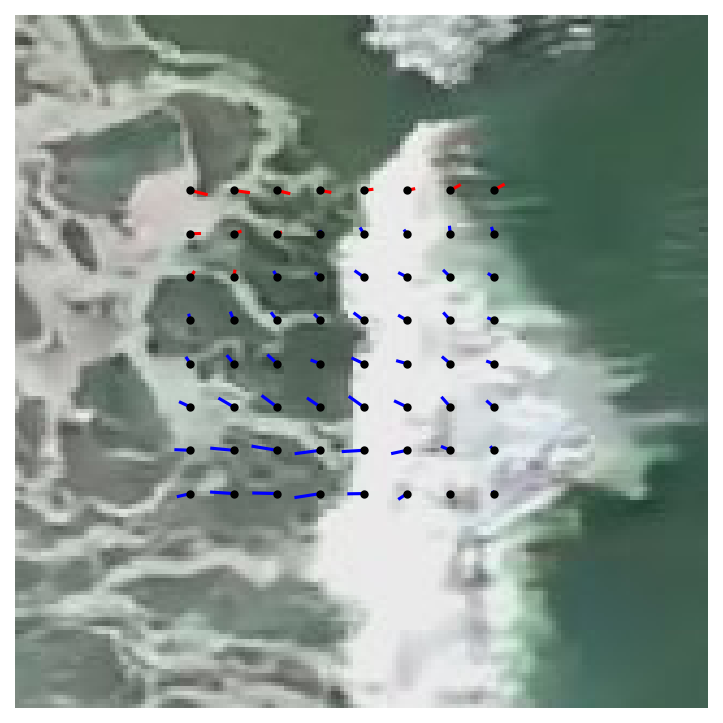

In [11]:
#Compute Lucas-Kanade
windowShift=10
speedY=5 #m/s
frameRate=10 #Hz
pixelSize=0.07 #m
compensateY= speedY / frameRate / pixelSize
print(compensateY)
#tileSpan=25
LKspan=25

f=plt.figure(dpi=150)
f.set_figwidth(10)
f.set_figheight(6)
imgplot_1 = plt.imshow(img_0[iY0:iY1, iX0:iX1])

for vX0 in range(40, 120, windowShift):
    for vY0 in range(40, 120, windowShift):
        x0=vX0
        y0=vY0
        mat_b = np.zeros([(2 * LKspan + 1)**2, 1])
        mat_A = np.zeros([(2 * LKspan + 1)**2, 2])
        count = 0
        for x in range(x0-LKspan, x0+LKspan+1):
            for y in range(y0-LKspan, y0+LKspan+1):
                mat_b[count] = diff_t[x,y]
                mat_A[count,0] = grad_x[x,y]
                mat_A[count,1] = grad_y[x,y]
                count += 1
        xy = - np.matmul( np.matmul( np.linalg.inv( np.matmul( np.transpose(mat_A), mat_A) ),  np.transpose(mat_A)), mat_b)
        vX=xy[0][0]
        vY=xy[1][0]
        #print(xy)
        if vX>0:
            lineColor='r'
        else:
            lineColor='b'    
        plt.plot([vX0, vX0+0.7*vX], [vY0, vY0+1*(vY-10)], lineColor)
        plt.plot([vX0],[vY0], '.k', linewidth=2)
plt.axis('off')

Compesantion vector Y:  5.0
DFD shape:  (100, 100)


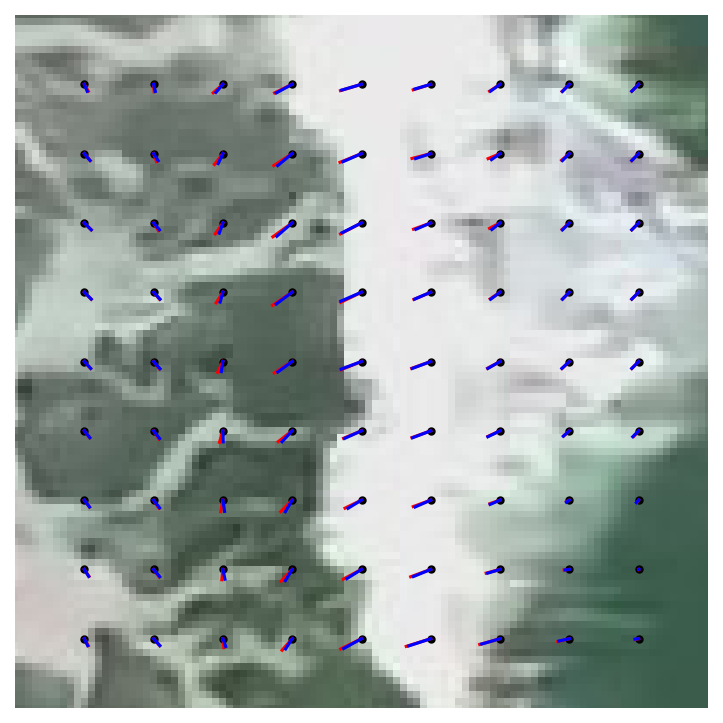

In [12]:
#Compare DFD and ECC
f=plt.figure(dpi=150)
f.set_figwidth(10)
f.set_figheight(6)

#plot flow vector
#drone speed compensation
windowSpanX=10
windowSpanY=10
windowShiftX=10
windowShiftY=10
#compensation parameters
speedY=5 #m/s
frameRate=10 #Hz
pixelSize=0.1 #m
compensateY= speedY / frameRate / pixelSize
print("Compesantion vector Y: ", compensateY)

print("DFD shape: ", DFD.shape)
(DFDheight,DFDwidth)=DFD.shape
imgplot_1 = plt.imshow(img_ref)
(imgY,imgX,imgZ)=img_ref.shape
for x in range(windowSpanY, DFDwidth-windowSpanX+1, windowShiftX ):
    for y in range(windowSpanY, DFDheight-windowSpanY+1, windowShiftY):
        #reference
        vX0=x + searchRange + tileSpan
        vY0=y + searchRange + tileSpan
        plt.plot([vX0],[vY0], '.k')
        #DFD
        vX=np.mean(DFDx[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        vY=np.mean(DFDy[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        if vX>0:
            lineColor='m'
        else:
            lineColor='c'    
        plt.plot([vX0, vX0+1*vX], [vY0, vY0+1*(vY-compensateY)], 'r')
        #ECC
        vX=np.mean(ECCx[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        vY=np.mean(ECCy[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        if vX>0:
            lineColor='r'
        else:
            lineColor='b'    
        plt.plot([vX0, vX0+1*vX], [vY0, vY0+1*(vY-compensateY)], 'b')

plt.axis('off')
plt.xlim(searchRange+tileSpan, imgX-searchRange-tileSpan)
plt.ylim(searchRange+tileSpan, imgY-searchRange-tileSpan)
plt.savefig('DFD1_test.png',bbox_inches='tight', pad_inches = 0)


Compesantion vector Y:  4
DFD shape:  (100, 100)


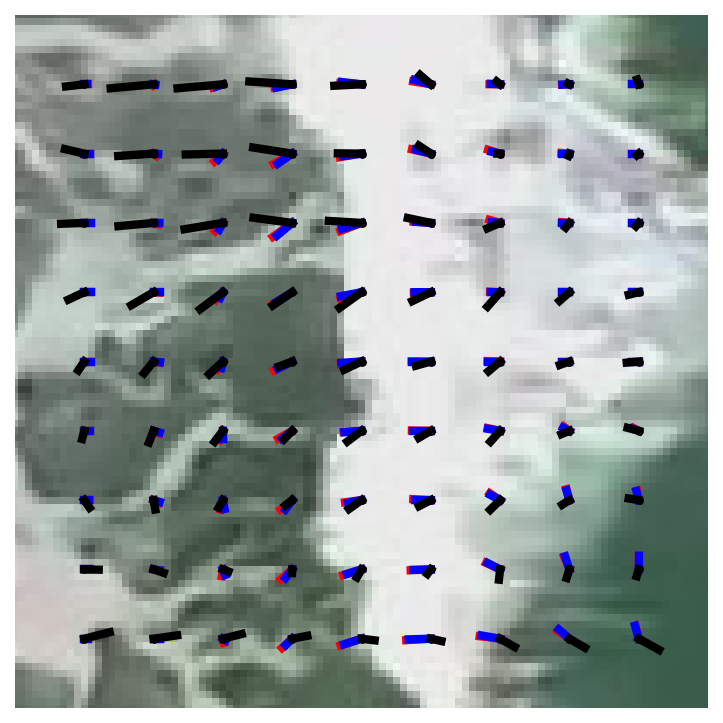

In [13]:
#Compare DFD, ECC, and Lucas-Kanade
f=plt.figure(dpi=150)
f.set_figwidth(10)
f.set_figheight(6)

#plot flow vector
#drone speed compensation
windowSpanX=10
windowSpanY=10
windowShiftX=10
windowShiftY=10
#compensation parameters
speedY=5 #m/s
frameRate=10 #Hz
pixelSize=0.1 #m
compensateY= speedY / frameRate / pixelSize
compensateY=4
print("Compesantion vector Y: ", compensateY)
    
print("DFD shape: ", DFD.shape)
(DFDheight,DFDwidth)=DFD.shape
imgplot_1 = plt.imshow(img_ref)
(imgY,imgX,imgZ)=img_ref.shape
for x in range(windowSpanY, DFDwidth-windowSpanX+1, windowShiftX ):
    for y in range(windowSpanY, DFDheight-windowSpanY+1, windowShiftY):
        #reference
        vX0=x + searchRange + tileSpan
        vY0=y + searchRange + tileSpan
        plt.plot([vX0],[vY0], '.k')
        #DFD
        vX=np.mean(DFDx[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        vY=np.mean(DFDy[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        if vX>0:
            lineColor='m'
        else:
            lineColor='c'    
        plt.plot([vX0, vX0+1*vX], [vY0, vY0+2*(vY-compensateY)], 'r', linewidth=4)
        #ECC
        vX=np.mean(ECCx[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        vY=np.mean(ECCy[y-windowSpanY:y+windowSpanY,x-windowSpanX:x+windowSpanX])
        if vX>0:
            lineColor='r'
        else:
            lineColor='b'    
        plt.plot([vX0, vX0+1*vX], [vY0, vY0+2*(vY-compensateY)], 'b', linewidth=4)
        

        x0=vX0
        y0=vY0
        mat_b = np.zeros([(2 * LKspan + 1)**2, 1])
        mat_A = np.zeros([(2 * LKspan + 1)**2, 2])
        count = 0
        for ix in range(x0-LKspan, x0+LKspan+1):
            for iy in range(y0-LKspan, y0+LKspan+1):
                mat_b[count] = diff_t[ix,iy]
                mat_A[count,0] = grad_x[ix,iy]
                mat_A[count,1] = grad_y[ix,iy]
                count += 1
        xy = - np.matmul( np.matmul( np.linalg.inv( np.matmul( np.transpose(mat_A), mat_A) ),  np.transpose(mat_A)), mat_b)
        vX=xy[0][0]
        vY=xy[1][0]

        if vX>0:
            lineColor='r'
        else:
            lineColor='b'    
        plt.plot([vX0, vX0+0.7*vX], [vY0, vY0+1*(vY-10)], 'k', linewidth=4)
        plt.plot([vX0],[vY0], '.k', linewidth=2)
        
plt.axis('off')
plt.xlim(searchRange+tileSpan, imgX-searchRange-tileSpan)
plt.ylim(searchRange+tileSpan, imgY-searchRange-tileSpan)
plt.savefig('DFD1_test.png',bbox_inches='tight', pad_inches = 0)
